In [2]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=pSUmrAEbbt24Cecx5uJ1vxLiTEdKDx&access_type=offline&code_challenge=C07TH7aMJH4j72V-3bmILTalanrw3WfgLUP7ZI2qoBg&code_challenge_method=S256


Credentials saved to file: [/Users/yt4/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "open-targets-genetics-dev" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


To take a quick anonymous survey, run:
  

In [ ]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=UiDTZiS2COSkwLlSyy0l1pVKoF8Yfg&access_type=offline&code_challenge=4jMAWGLzSEe-ozTnSiVWYKCSv6hg9PyZzX727eiHbYk&code_challenge_method=S256


You are now logged in as [yt4@sanger.ac.uk].
Your current project is [open-targets-genetics-dev].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update



In [ ]:
import os

import hail as hl
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql import DataFrame

from gentropy.common.session import Session
from gentropy.dataset.study_index import StudyIndex
from gentropy.dataset.summary_statistics import SummaryStatistics
from gentropy.dataset.study_locus import StudyLocus
from gentropy.susie_finemapper import SusieFineMapperStep
from gentropy.method.drug_enrichment_from_evid import chemblDrugEnrichment

"""Common utilities for the project."""

import os
from pathlib import Path
from gentropy.common.session import Session
import logging


def get_gcs_credentials() -> str:
    """Get the credentials for google cloud storage."""
    app_default_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/application_default_credentials.json"
    )

    service_account_credentials = os.path.join(
        os.getenv("HOME", "."), ".config/gcloud/service_account_credentials.json"
    )

    if Path(app_default_credentials).exists():
        return app_default_credentials
    else:
        raise FileNotFoundError("No GCS credentials found.")


def get_gcs_hadoop_connector_jar() -> str:
    """Get the google cloud storage hadoop connector for spark.

    This function will return the url to download the hadoop jar.
    """

    return (
        "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar"
    )


def gcs_conf(
    credentials_path=None, project="open-targets-genetics-dev"
) -> dict[str, str]:
    """Get the spark configuration with hadoop connector for google cloud storage."""
    credentials_path = credentials_path or get_gcs_credentials()
    return {
        "spark.driver.memory": "12g",
        "spark.kryoserializer.buffer.max": "500m",
        "spark.driver.maxResultSize":"2g",
        "spark.hadoop.fs.gs.impl": "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem",
        "spark.jars": get_gcs_hadoop_connector_jar(),
        "spark.hadoop.google.cloud.auth.service.account.enable": "true",
        "spark.hadoop.fs.gs.project.id": project,
        "spark.hadoop.google.cloud.auth.service.account.json.keyfile": credentials_path,
        "spark.hadoop.fs.gs.requester.pays.mode": "AUTO",
    }


class GentropySession(Session):
    def __init__(self, *args, **kwargs):
        if "extended_spark_conf" in kwargs:
            kwargs["extended_spark_conf"].update(gcs_conf())
        else:
            kwargs["extended_spark_conf"] = gcs_conf()
        super().__init__(*args, **kwargs)

    @property
    def conf(self):
        logging.warning(
            "To change the config restart the session and use the `extended_spark_conf` parameter."
        )
        return self.spark.sparkContext.getConf().getAll()

session= GentropySession()


path_to_release_folder="gs://open-targets-data-releases/25.03/"
#path_to_release_folder="gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/"
#path_to_release_folder="gs://ot_orchestration/releases/25.02_freeze1/"

si=StudyIndex.from_parquet(session,path_to_release_folder+"output/study/")
sl=StudyLocus.from_parquet(session,path_to_release_folder+"output/credible_set/")

Loading BokehJS ...

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 21:49:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ERROR:root:Exception while sending command.                         (0 + 4) / 4]
Traceback (most recent call last):
  File "/Users/yt4/Projects/gentropy/.venv/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: reentrant call inside <_io.BufferedReader name=76>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yt4/Projects/gentropy/.venv/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Py4JError: An error occurred while calling o66.isEmpty

# Old and new L2Gs

In [2]:
old_l2g=session.spark.read.parquet("gs://open-targets-pre-data-releases/partners/24.12/output/etl/parquet/evidence/sourceId=ot_genetics_portal")
old_l2g=old_l2g.select("targetId","diseaseId","studyId","score","variantId").withColumnRenamed("score","resourceScore").cache()
old_l2g.count()

781184

In [3]:
# combinig it with l2g predictions
l2g=session.spark.read.parquet(path_to_release_folder+"output/l2g_prediction")

In [4]:
new_l2g_evidence=chemblDrugEnrichment.to_disease_target_evidence(table_with_score=l2g,
    score_column="score",
    datasource_id="new_l2g",
    study_locus=sl,
    study_index=si,
    min_score=0
).cache()

In [5]:
new_l2g_evidence.count()

1082677

In [6]:
disease_index_path=path_to_release_folder+"output/disease/disease.parquet"
disease_index_orig = session.spark.read.parquet(disease_index_path)

platform_chembl_evidence_path=path_to_release_folder+"output/evidence/sourceId=chembl"
chembl_evidence=session.spark.read.parquet(platform_chembl_evidence_path)

In [11]:
import pandas as pd
all_enrich = []

In [12]:
#Old l2g
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=old_l2g,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence,
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "L2G_24.09"
all_enrich.append(enrich)

25/04/24 23:28:24 WARN CacheManager: Asked to cache already cached data.        
25/04/24 23:28:25 WARN CacheManager: Asked to cache already cached data.        


In [13]:
#New l2g
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=new_l2g_evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence, 
    indirect_assoc_score_thr=0.5,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "new_L2G_05"
all_enrich.append(enrich)

25/04/24 23:28:51 WARN CacheManager: Asked to cache already cached data.        
25/04/24 23:28:52 WARN CacheManager: Asked to cache already cached data.        


In [14]:
#New l2g
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=new_l2g_evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence, 
    indirect_assoc_score_thr=0.8,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "new_L2G_08"
all_enrich.append(enrich)

25/04/24 23:29:14 WARN CacheManager: Asked to cache already cached data.        


In [15]:
#New l2g
enrich=chemblDrugEnrichment.drug_enrichemnt_from_evidence(
    evid=new_l2g_evidence,
    disease_index_orig=disease_index_orig,
    chembl_orig=chembl_evidence, 
    indirect_assoc_score_thr=0.05,
    efo_ancestors_to_remove=["MONDO_0045024"]
)
enrich["datasource"] = "new_L2G_005"
all_enrich.append(enrich)

25/04/24 23:29:53 WARN CacheManager: Asked to cache already cached data.        


In [16]:
combined_enrich = pd.concat(all_enrich, ignore_index=True)

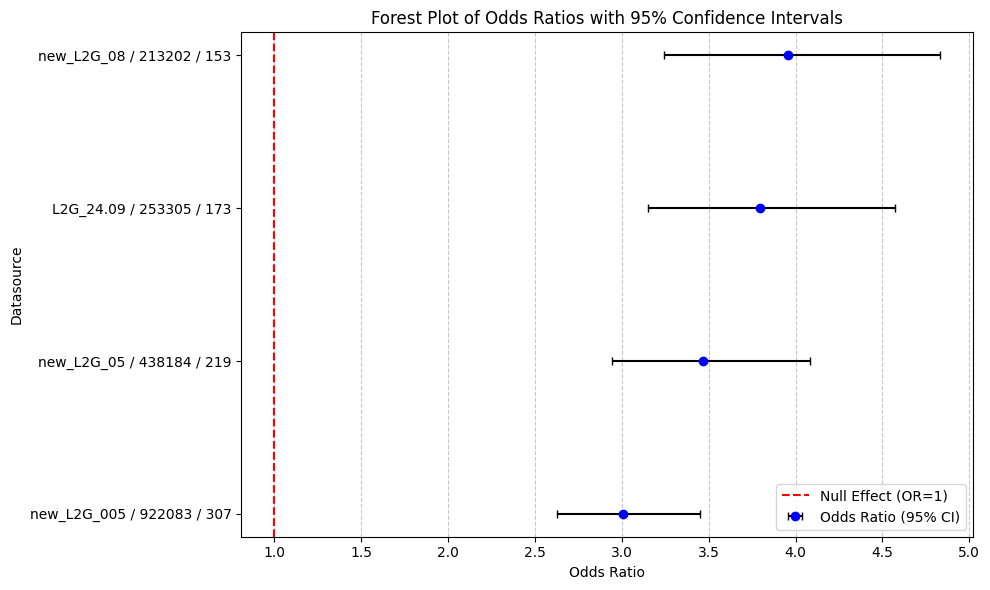

In [17]:
import matplotlib.pyplot as plt

# Assuming `combined_enrich` is your pandas DataFrame
# Sort the DataFrame by odds_ratio for better visualization
combined_enrich_4=combined_enrich[combined_enrich["clinicalPhase"]=="4+"]
combined_enrich_4 = combined_enrich_4.sort_values(by="odds_ratio", ascending=True)

# Extract data for the plot
datasources = combined_enrich_4.apply(
    lambda row: f"{row['datasource']} / {row['total_indirect_assoc']} / {row['yes_evid-high_clinphase']}", axis=1
)
odds_ratios = combined_enrich_4["odds_ratio"]
ci_low = combined_enrich_4["ci_low"]
ci_high = combined_enrich_4["ci_high"]

# Create the forest plot
plt.figure(figsize=(10, 6))
plt.errorbar(odds_ratios, datasources, xerr=[odds_ratios - ci_low, ci_high - odds_ratios], fmt='o', color='blue', ecolor='black', capsize=3, label="Odds Ratio (95% CI)")

# Add labels and title
plt.axvline(x=1, color='red', linestyle='--', label="Null Effect (OR=1)")
plt.xlabel("Odds Ratio")
plt.ylabel("Datasource")
plt.title("Forest Plot of Odds Ratios with 95% Confidence Intervals")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
folder_to_save="chembl_enrichment/"
combined_enrich.to_csv(folder_to_save+"old_l2g_new_l2g.csv", index=False)

25/04/25 03:22:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 974249 ms exceeds timeout 120000 ms
25/04/25 03:22:19 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/25 03:22:24 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$